# Using GPs.jl

In [4]:
using LinearAlgebra
using Plots
using Distributions
using Random; Random.seed!(1234);

In [5]:
include("../src/GP.jl")
using .GPs

In [6]:
f = GP(rbf([1.], [1.]))
ϵ = GP(noise([0.2]))
y = f + ϵ;

In [7]:
Xs = 0:0.01:10;

### Prior

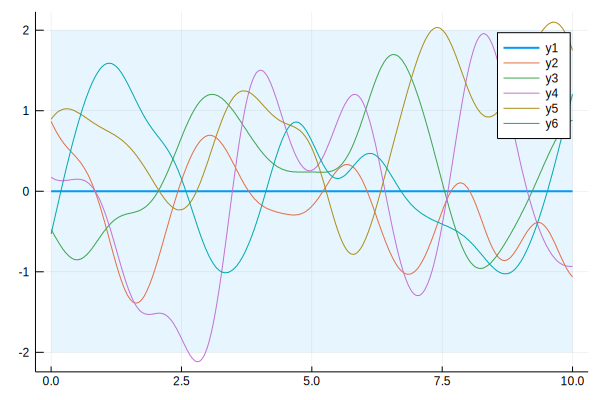

In [8]:
plot(Xs, f(Xs))
plot!(Xs, rand(f(Xs), 5))

### Posterior
First generate some evidence, then get a pretty posterior formulation.

In [9]:
_y = GPs.GP(GPs.constant_mean(-1.), GPs.rbf([0.5], [2])) + GPs.GP(GPs.noise([0.5]))
n = 10
X̂ = rand(n).*8 .+ 1
ŷ = rand(_y(X̂))
[X̂ ŷ]

10×2 Array{Float64,2}:
 5.29135   0.555389
 8.65052  -1.86947 
 4.64247   1.89542 
 8.88773  -2.76828 
 4.59779   1.26823 
 7.91228  -0.550772
 3.60808  -3.47448 
 1.72701  -5.78202 
 6.705     0.822656
 7.18178   0.502706

In [10]:
struct Evidence
    gp::GP
    X::Array
    y::Array
end
←(gp::GP, obs::Tuple{Array, Array}) = Evidence(gp, obs[1], obs[2])
function |(gp::GP, evidence::Evidence)
    y = evidence.gp
    X̂, ŷ = evidence.X, evidence.y
    Δy = ŷ - gp.μ(X̂)
    K_inv = inv(Symmetric(y.k(X̂, X̂) + 1e-6*I))
    
    μ(x) = gp.μ(x) .+ gp.k(x, X̂) * K_inv * Δy
    k(x₁, x₂) = gp.k(x₁, x₂) - gp.k(x₁, X̂) * K_inv * gp.k(X̂, x₂)
    
    return GPs.GP(μ, k)
end

| (generic function with 1 method)

In [11]:
f′ = f | (y ← (X̂, ŷ))

GP(getfield(Main, Symbol("#μ#3")){GP,Array{Float64,1},Array{Float64,1},Symmetric{Float64,Array{Float64,2}}}(GP(getfield(Main.GPs, Symbol("##1#2"))(), getfield(Main.GPs, Symbol("##5#6")){Array{Float64,1},Array{Float64,1}}([1.0], [1.0])), [5.29135, 8.65052, 4.64247, 8.88773, 4.59779, 7.91228, 3.60808, 1.72701, 6.705, 7.18178], [0.555389, -1.86947, 1.89542, -2.76828, 1.26823, -0.550772, -3.47448, -5.78202, 0.822656, 0.502706], [1.75678 0.096127 … -0.501963 0.424082; 0.096127 9.0483 … -0.82437 1.82991; … ; -0.501963 -0.82437 … 3.01566 -2.96541; 0.424082 1.82991 … -2.96541 4.50784]), getfield(Main, Symbol("#k#4")){GP,Array{Float64,1},Symmetric{Float64,Array{Float64,2}}}(GP(getfield(Main.GPs, Symbol("##1#2"))(), getfield(Main.GPs, Symbol("##5#6")){Array{Float64,1},Array{Float64,1}}([1.0], [1.0])), [5.29135, 8.65052, 4.64247, 8.88773, 4.59779, 7.91228, 3.60808, 1.72701, 6.705, 7.18178], [1.75678 0.096127 … -0.501963 0.424082; 0.096127 9.0483 … -0.82437 1.82991; … ; -0.501963 -0.82437 … 3.0156

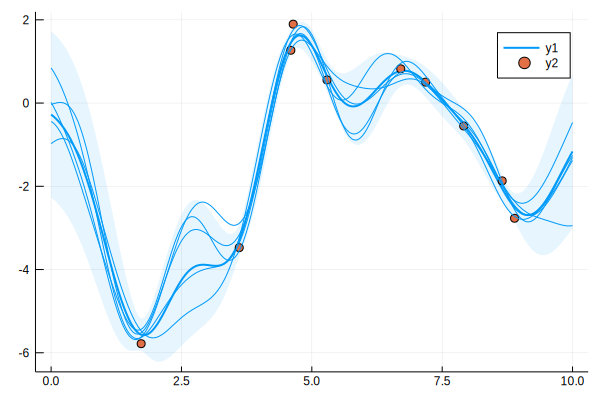

In [14]:
plot(Xs, f′(Xs))
scatter!(X̂, ŷ, color=2)
plot!(Xs, rand(f′(Xs), 5), color=1, label="")